Neural Networks From Scratch
The idea is that we show the very explicit implementation in NumPy, where we have to do much of the work, then afterwards, we switch to the most popular Python packages for building neural networks, to show just how easier it makes our lives.


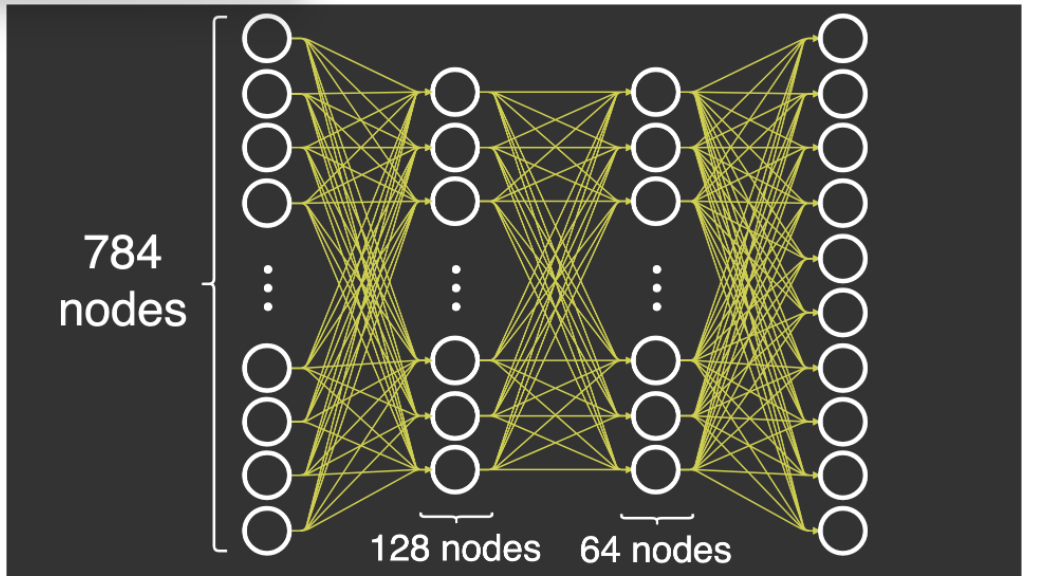


NumPy
TensorFlow
PyTorch
Made for and explained at mlfromscratch.com/neural-networks-tutorial/.

We will focus on the following 4-layer neural network, with fully connected layers in this notebook. Ideally, you can develop further on and improve the NumPy approach, while modifying the layers in PyTorch and TensorFlow to use convolutions and filters.

Exercises
These exercises could improve the network's performance. There are no solutions, but it's good to try and solve them to get better knowledge of how neural networks work.

Easy: Implement the ReLU activation function, or any other activation function from this overview of activation functions. Check how the sigmoid functions are implemented for reference, and remember to implement the derivative as well. Use the ReLU activation function in place of the sigmoid function.

Easy: Initialize biases and add them to Z before the activation function in the forward pass, and update the biases in the backward pass.

Medium: Optimize the forward and backward pass, such that they run in a for-loop in each function. This makes the code easier to modify and possibly easier to maintain.

Optimize the initialization function that makes weights for the neural network, such that you can modify the sizes=[] argument without the neural network failing.
Medium: Implement mini-batch gradient descent, replacing stochastic gradient descent. Instead of making an update to a parameter for each sample, make an update based on the averaged value of each sample in a mini-batch. The size of the mini-batch is usually below 64.

Hard: Implement the Adam optimizer, described in this overview of optimizers. This should be implemented in the train function.

Implement Momentum by adding the extra term.
Implement an adaptive learning rate, based on the AdaGrad optimizer.
Use step a and b to finally implement Adam.


In [1]:
from sklearn.datasets import fetch_openml
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
import time

x, y = fetch_openml('mnist_784', version=1, as_frame=True,return_X_y=True)
x = (x.values/255).astype('float32')
y = to_categorical(y.values)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)



In [2]:
len(x)

70000

In [3]:
class DeepNeuralNetwork():
    def __init__(self, sizes, epochs=50, l_rate=0.001, mini_batch_size = 32):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.mini_batch_size = mini_batch_size

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()
    
    def chunks(self,lst, n):
        for i in range(0, len(lst), n):
            yield lst[i:i + n]

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def relu(self, x, derivative=False):
        if derivative:
            return (x > 0)* 1.0
        else:
            return np.maximum(x,0)
    
    
    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer),
            'b1':np.random.randn(hidden_1)*0.1,
            'b2':np.random.randn(hidden_2)*0.1,
            'b3':np.random.randn(output_layer)*0.1
                    
        }

        return params

    def forward_pass(self, x_mini_batch):
        
        batch_params = {'A0':[],'A1':[],'Z1':[],'A2':[],'Z2':[],'A3':[],'Z3':[]}
        
        for x_train in x_mini_batch:
            local_params = self.params.copy()
        
        # input layer activations becomes sample
            local_params['A0']= x_train
            batch_params['A0'].append( x_train)
        
        # input layer to hidden layer 1
            local_params['Z1']=np.dot(local_params['W1'], local_params['A0'])+local_params['b1']
            local_params['A1']= self.relu(local_params['Z1'])
            batch_params['Z1'].append(local_params['Z1'])
            batch_params['A1'].append(local_params['A1'])

            # hidden layer 1 to hidden layer 2
            local_params['Z2']= np.dot(local_params["W2"], local_params['A1'])+local_params['b2']
            batch_params['Z2'].append(local_params['Z2']) 
            #params['A2'] = self.sigmoid(params['Z2'])
            local_params['A2']= self.relu(local_params['Z2'])
            batch_params['A2'].append( local_params['A2'])

            # hidden layer 2 to output layer
            local_params['Z3'] = np.dot(local_params["W3"], local_params['A2'])+local_params['b3']
            local_params['A3'] = self.softmax(local_params['Z3'])
            batch_params['A3'].append( local_params['A3'])
            batch_params['Z3'].append( local_params['Z3'])
            
            
        return batch_params
    
    def forward_pass_matrix(self, x_mini_batch):
        
        batch_params = {'A0':[],'A1':[],'Z1':[],'A2':[],'Z2':[],'A3':[],'Z3':[]}
        
        
        local_params = self.params.copy()
        
        # input layer activations becomes sample
        batch_params['A0']= np.transpose(x_mini_batch)
        
        # input layer to hidden layer 1
        local_params['Z1']=np.matmul(np.transpose(local_params['W1']), batch_params['A0'])+local_params['b1']
        local_params['A1']= self.relu(local_params['Z1'])
            batch_params['Z1'].append(local_params['Z1'])
            batch_params['A1'].append(local_params['A1'])

            # hidden layer 1 to hidden layer 2
            local_params['Z2']= np.dot(local_params["W2"], local_params['A1'])+local_params['b2']
            batch_params['Z2'].append(local_params['Z2']) 
            #params['A2'] = self.sigmoid(params['Z2'])
            local_params['A2']= self.relu(local_params['Z2'])
            batch_params['A2'].append( local_params['A2'])

            # hidden layer 2 to output layer
            local_params['Z3'] = np.dot(local_params["W3"], local_params['A2'])+local_params['b3']
            local_params['A3'] = self.softmax(local_params['Z3'])
            batch_params['A3'].append( local_params['A3'])
            batch_params['Z3'].append( local_params['Z3'])
            
            
        return batch_params

    def backward_pass(self, y_batch, params):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is 
                  caused  by the dot and multiply operations on the huge arrays.
                  
                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        
        change_w = {'W3':[], 'b3':[],'W2':[], 'b2':[],'W1':[],'b1':[]}
        for y_train, i in zip(y_batch,range(len(y_batch))):
                                          
            output = params['A3'][i]
            
        # Calculate W3 update
            error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'][i], derivative=True)
            change_w['W3'].append(np.outer(error, params['A2'][i]))
            change_w['b3'].append(2 * (output - y_train) / output.shape[0])
        
        # Calculate W2 update
        #error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
            error_i = error
            error = np.dot(self.params['W3'].T, error) * self.relu(params['Z2'][i], derivative=True)
            change_w['W2'].append(np.outer(error, params['A1'][i]))
            change_w['b2'].append(np.dot(self.params['W3'].T, error_i))
        
        # Calculate W1 update
        #error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
            error_i = error
            error = np.dot(self.params['W2'].T, error) * self.relu(params['Z1'][i], derivative=True)
            change_w['W1'].append(np.outer(error, params['A0'][i]))
            change_w['b1'].append(np.dot(self.params['W2'].T, error_i))
        
        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y), 
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''
        for key, value in changes_to_w.items():   
            #if key == 'b3':
            #    print("a",self.params[key])
            #    print("b", np.mean(value,axis=0))
            self.params[key] -= self.l_rate * np.mean(value,axis=0)
            #if key == 'b3':
            #    print("c",self.params[key])
          
             
    def compute_accuracy(self, x_val, y_val):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []
        output= self.forward_pass(x_val)
        for x, y in zip(output['A3'],y_val):
            pred = np.argmax(x)
            #print(pred)
            predictions.append(pred == np.argmax(y))
        return np.mean(predictions)

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        '''
        for iteration in range(self.epochs):
            for x,y in zip(x_train.values, y_train):
                #print("im here", x)
                try:
                    output = self.forward_pass(x)
                    changes_to_w = self.backward_pass(y, output)
                    self.update_network_parameters(changes_to_w)
                except:
                    continue
        '''
        
        '''
        1. Implement minibatch
        
        '''
        
        
        
        for iteration in range(self.epochs):
            for chunk_x, chunk_y in zip(self.chunks(x_train,self.mini_batch_size), self.chunks(y_train,self.mini_batch_size)):
                output = self.forward_pass(chunk_x)
                changes_to_w = self.backward_pass(chunk_y, output)
                #print(changes_to_w)
                self.update_network_parameters(changes_to_w)
                
        
            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100
            ))

In [ ]:
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10],epochs=100,l_rate=0.07)
dnn.train(x_train, y_train, x_val, y_val)
#dnn.train(x, y, x, y)

Epoch: 1, Time Spent: 33.46s, Accuracy: 85.19%
Epoch: 2, Time Spent: 65.66s, Accuracy: 89.01%
Epoch: 3, Time Spent: 99.81s, Accuracy: 90.31%
Epoch: 4, Time Spent: 135.55s, Accuracy: 91.02%


In [ ]:
change_w
